In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
data = pd.read_json('cmpt-history.ndjson.gz', lines=True, convert_dates=['date'])

In [5]:
#Convert semester code into enrollment date for each term
def semester_to_enrollment_date(semester):
    semester_str = str(semester)
    #Extracting relevant information from semester column value
    century = int(semester_str[0])
    year = int(semester_str[1:3])
    term = int(semester_str[3])
    
    #get dictionary key
    key = int(semester_str[1:])
    
    year = year + (20 + century - 1) * 100
    
    if term == 1:
        year = year -1 #Enrollment for Spring Term is on the year before 
        month = 11 #Spring Term Enrollment Month is November
    elif term == 4:
        month = 3 #Summer Term Enrollment Month is March for all sessions
    elif term == 7:
        month = 7 #Fall Term Enrollment Month is July
    
    #Enrollment date for each term, key extracted from the last 3 digit of semester code
    enrollment_date_dict = {
        171: 7,
        174: 6,
        177: 11,
        181: 6,
        184: 5,
        187: 9,
        191: 5,
        194: 4,
        197: 8,
        201: 4,
        204: 2,
        207: 6,
        211: 9,
        214: 8,
        217: 5,
        221: 8,
        224: 7,
        227: 4,
        231: 7,
        234: 6,
        237: 4    
    }
    
    default_day = 1
    day = enrollment_date_dict.get(key, default_day)
    
    return pd.to_datetime(f"{year}-{month:02d}-{day}")

data['enrollment_date'] = data['semester'].apply(semester_to_enrollment_date)

In [6]:
#Convert semester code into enrollment closing date for each term
def semester_to_enrollment_closing_date(semester):
    semester_str = str(semester)
    #Extracting relevant information from semester column value
    century = int(semester_str[0])
    year = int(semester_str[1:3])
    term = int(semester_str[3])
        
    #get dictionary key
    key = int(semester_str[1:])
    
    year = year + (20 + century - 1) * 100
    
    if term == 1:
        month = 1
    elif term == 4:
        month = 5
    elif term == 7:
        month = 9
        
    #For each term, enrollment closed approximately 1 weeks after the class start    
    enrollment_closing_date_dict = {
        171: 10,
        174: 14,
        177: 11,
        181: 9,
        184: 13,
        187: 10,
        191: 9,
        194: 12,
        197: 9,
        201: 12,
        204: 17,
        207: 15,
        211: 17,
        214: 18,
        217: 14,
        221: 16,
        224: 16,
        227: 12,
        231: 10,
        234: 14,
        237: 12    
    }
    
    default_day = 1
    day = enrollment_closing_date_dict.get(key, default_day)
    
    return pd.to_datetime(f"{year}-{month:02d}-{day}")

data['enrollment_closing_date'] = data['semester'].apply(semester_to_enrollment_closing_date)

In [7]:
# Filtering: We don't need CHIN & DDP courses, co-op courses, research courses, or graduate level courses. We can filter these out
# Note: Even though research project courses can be full, we omit the courses as it is too dependent on non-quantifiable factors (eg: research topic, professor, etc.)
# Note: We also filter data on unncessary date since we are gauging student's interest on each class based on how long it take to hit a cap and how many people could not get in by the end

data = data.loc[data['subject'].apply(lambda x: x == 'CMPT' or x == 'MACM')] # Filtering non-CMPT or MACM courses
data = data.loc[data['number'].apply(lambda x: int(x[:3])<500)] # Filtering graduate-level courses, note: [:3] is to avoid edge cases such as 105W
data = data.loc[data['number'].apply(lambda x: int(x[:3]) < 426 or int(x[:3]) > 430)] # Filtering co-op courses
data = data.loc[data['number'].apply(lambda x: int(x[:3]) < 415 or int(x[:3]) > 416)] # Filtering research courses
data = data.loc[data['semester'].apply(lambda x: x < 1241 )] #Filtering all courses listed for Spring 2024
data = data[data.apply(lambda row: row['enrollment_date'] <= row['date'] <= row['enrollment_closing_date'], axis=1)]
# Note: Semester data, eg. 1241 : 
# First digit: 2x-th century, eg: 1 means 21st century
# Second and third digit: year 20xx, eg: 24 means 2024
# Fourth digit: Spring (1), Summer (4), Fall (7)

In [8]:
# Test: Graphing the enrollment data of CMPT 433

testData = data.loc[data['number'] == '433']
testData = testData.loc[testData['semester'] >= 1231]
testData = testData.sort_values(by=['date'])
# testData


In [11]:
# Note: enrollment start for spring 23: '2022-11-07'
# Drop deadline for spring 23: '2023-01-18'
spring23_433 = testData.loc[testData['date'] < '2023-01-18']
spring23_433 = testData.loc[testData['date'] >= '2022-11-07']
#spring24_433 = testData.loc[testData['date'] >= '2023-11-06']

(array([19304., 19311., 19318., 19327., 19334., 19341., 19348., 19358.,
        19365.]),
 [Text(19304.0, 0, '2022-11-08'),
  Text(19311.0, 0, '2022-11-15'),
  Text(19318.0, 0, '2022-11-22'),
  Text(19327.0, 0, '2022-12-01'),
  Text(19334.0, 0, '2022-12-08'),
  Text(19341.0, 0, '2022-12-15'),
  Text(19348.0, 0, '2022-12-22'),
  Text(19358.0, 0, '2023-01-01'),
  Text(19365.0, 0, '2023-01-08')])

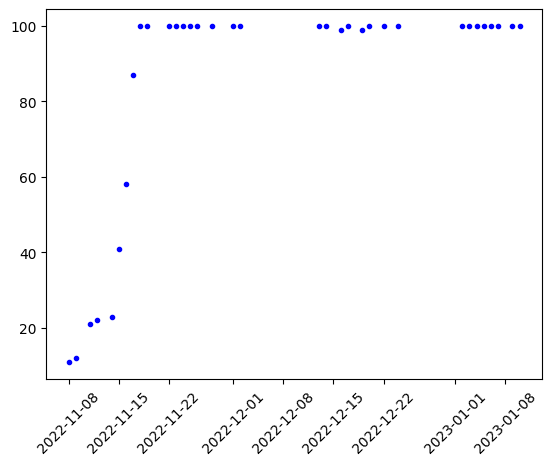

In [12]:
plt.plot(spring23_433['date'], spring23_433['enrl_tot'], 'b.')
plt.xticks(rotation=45)
